# Imports and init constants

In [1]:
!rm -r ./reduce-mode-collapse-in-gan
!git clone -b synthetic_experiment https://github.com/ThViviani/reduce-mode-collapse-in-gan.git

import sys; sys.path.append('./reduce-mode-collapse-in-gan')

rm: cannot remove './reduce-mode-collapse-in-gan': No such file or directory
Cloning into 'reduce-mode-collapse-in-gan'...
remote: Enumerating objects: 242, done.
remote: Total 242 (delta 0), reused 0 (delta 0), pack-reused 242 (from 1)
Receiving objects: 100% (242/242), 2.24 MiB | 28.02 MiB/s, done.
Resolving deltas: 100% (148/148), done.


In [2]:
!pip install -r ./reduce-mode-collapse-in-gan/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.3/797.3 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import lightning as L
import torch
import torchvision
import torch.utils
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np
import torch_fidelity
import wandb

from torch.utils.data import Dataset
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch import Trainer, seed_everything

In [4]:
torch.cuda.is_available()

True

In [ ]:
BACTH_SIZE = 256
LATENT_SPACE_DIM = 100
WANDB_TOKEN = '' # input your wandb token
PATH_TO_CHECKPOINT = ''
SEED = 999
MAX_EPOCHS = 20

seed_everything(SEED)

INFO: Seed set to 999


999

In [6]:
wandb.login(key=WANDB_TOKEN)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: developsviviani (developsviviani-clown-dev) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# Preparing MNIST

In [7]:
compose = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = torchvision.datasets.MNIST('MNIST/raw/train-images-idx3-ubyte', download=True, train=True, transform=compose)
val_dataset = torchvision.datasets.MNIST('MNIST/raw/train-images-idx3-ubyte', download=True, train=False, transform=compose)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:00<00:00, 17635665.58it/s]


Extracting MNIST/raw/train-images-idx3-ubyte/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw/train-images-idx3-ubyte/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 480272.19it/s]


Extracting MNIST/raw/train-images-idx3-ubyte/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw/train-images-idx3-ubyte/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 4399189.74it/s]


Extracting MNIST/raw/train-images-idx3-ubyte/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw/train-images-idx3-ubyte/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 6772317.37it/s]

Extracting MNIST/raw/train-images-idx3-ubyte/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw/train-images-idx3-ubyte/MNIST/raw



In [8]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BACTH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=BACTH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# Networks

In [9]:
from models.discriminators import CriticMNIST
from models.generators import GeneratorMNIST
from models.encoders import EncoderMNIST

g = GeneratorMNIST().cuda()
print(g(torch.randn((BACTH_SIZE, LATENT_SPACE_DIM)).cuda()).shape)

critic = CriticMNIST()
b = next(iter(train_loader))
critic(b[0]).shape

encoder = EncoderMNIST((1, 28, 28), LATENT_SPACE_DIM).cuda()
encoder(b[0].cuda())

torch.Size([256, 1, 28, 28])


tensor([[-0.0201,  0.2004,  0.1393,  ..., -0.6318, -0.3123, -0.1699],
        [-0.1618,  0.5511,  0.4073,  ..., -0.3553, -0.2400, -0.3492],
        [ 0.0302,  0.2948,  0.3224,  ..., -0.5604, -0.3168, -0.9010],
        ...,
        [-0.1404,  0.2628, -0.0431,  ..., -1.1945, -0.4687, -0.4417],
        [-0.6978,  0.1057, -0.2172,  ..., -0.7449, -0.4537, -0.0131],
        [ 0.2597, -0.1506,  0.0294,  ..., -0.7939, -0.5304, -0.9943]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

# Experiments

In [10]:
class GeneratorForFIDWrapper(nn.Module):
    """A wrapper which transforms generator's images from [-1, 1] to [0, 255] and [B, 1, H, W] -> [B, 3, H, W]"""

    def __init__(self, generator, device, img_size=299):
        super().__init__()
        self.generator = generator
        self.img_size = img_size
        self.device = device

    def forward(self, z):
        with torch.no_grad():
            imgs = self.generator(z)  # [B, 1, H, W], float32, [-1, 1]
            imgs = (imgs + 1) / 2  # [-1, 1] → [0, 1]
            imgs = imgs * 255
            imgs = imgs.clamp(0, 255).to(torch.uint8)

            if imgs.shape[1] == 1:
                imgs = imgs.repeat(1, 3, 1, 1)  # [B, 1, H, W] → [B, 3, H, W]

        return imgs

class DatasetForFIDWrapper(Dataset):
    """A dataset wrapper which returns only images (without labels)"""
    def __init__(self, dataset_class, **kwargs):
        """
            Args:
                dataset_class: Dataset class to wrap (e.g., torchvision.datasets.MNIST)
                **kwargs: All arguments required to initialize the dataset_class
        """
        self.dataset = dataset_class(**kwargs)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, _ = self.dataset[idx]
        image = (image + 1) / 2  # [-1, 1] → [0, 1]
        image = image * 255
        image = image.clamp(0, 255).to(torch.uint8) # -> [0, 255]
        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)
        return image

In [11]:
compose = transforms.Compose([
    transforms.ToTensor(),
])

ROOT_TO_REGISTER_DATASET_FOR_FID = 'test_dataset'

test_ds = torch_fidelity.register_dataset(
    ROOT_TO_REGISTER_DATASET_FOR_FID,
    lambda root, download: DatasetForFIDWrapper(torchvision.datasets.MNIST, root=root, download=download, train=False, transform=compose)
)

In [12]:
import gc

def compute_metrics(model, seed, latent_space_dim, input2, input2_root='MNIST/raw/train-images-idx3-ubyte'):
    generator = GeneratorForFIDWrapper(model.generator, model.device)
    wrapped_generator = torch_fidelity.GenerativeModelModuleWrapper(generator, latent_space_dim, 'normal', 0)

    metrics_dict = torch_fidelity.calculate_metrics(
        input1=wrapped_generator,
        input2=input2,
        input1_model_num_samples=10000,
        input2_model_num_samples=10000,
        cuda=True,
        isc=True,
        fid=True,
        verbose=False,
        input2_root=input2_root,
        datasets_download=True,
        rng_seed=seed,
    )

    print(metrics_dict)
    del generator
    del wrapped_generator
    gc.collect()
    torch.cuda.empty_cache()

    return metrics_dict

In [13]:
from trainers.neighbors_embedding_gan import NEVanilaGAN, NERpGAN
from trainers.dist_gan import DistVanilaGAN, DistRpGAN
from trainers.standard_gan import StandardGAN
from trainers.rp_gan import RpGAN
from models.discriminators import CriticMNIST
from datetime import datetime
from trainers.dp_gan import DpVanilaGan, DpRpGAN
from trainers.ne_gan_without_ae import NEVanilaGAN_hat, NERpGAN_hat

import pandas as pd


def create_model_fn(model_class, use_encoder=False, use_r1r2=False):
    def wrapper():
        if model_class.__name__.find('Rp') != -1:
            return model_class(
                critic=CriticMNIST(),
                generator=GeneratorMNIST(),
                encoder=EncoderMNIST((1, 28, 28), LATENT_SPACE_DIM) if use_encoder else None,
                use_r1r2_penalty=use_r1r2
            )
        else:
            return model_class(
                critic=CriticMNIST(),
                generator=GeneratorMNIST(),
                encoder=EncoderMNIST((1, 28, 28), LATENT_SPACE_DIM) if use_encoder else None,
            )
    return wrapper


EXPERIMENTS = {
    'DpVanilaGAN': create_model_fn(DpVanilaGan),
    'NEVanilaGAN': create_model_fn(NEVanilaGAN, use_encoder=True),
    'DistVanilaGAN': create_model_fn(DistVanilaGAN, use_encoder=True),
    'NEVanilaGAN_hat': create_model_fn(NEVanilaGAN_hat),
    'StandardGAN': create_model_fn(StandardGAN),
    'RpGAN': create_model_fn(RpGAN),
    'NERpGAN_hat': create_model_fn(NERpGAN_hat),
    'DistRpGAN': create_model_fn(DistRpGAN, use_encoder=True),
    'NERpGAN': create_model_fn(NERpGAN, use_encoder=True),
    'DpRpGAN': create_model_fn(DpRpGAN),
    'RpGAN_R1R2': create_model_fn(RpGAN, use_r1r2=True),
    'NERpGAN_hat+R1R2': create_model_fn(NERpGAN_hat, use_r1r2=True),
    'DistRpGAN+R1R2': create_model_fn(DistRpGAN, use_encoder=True, use_r1r2=True),
    'NERpGAN+R1R2': create_model_fn(NERpGAN, use_encoder=True, use_r1r2=True),
    'DpRpGAN+R1R2': create_model_fn(DpRpGAN, use_r1r2=True),
}

results = pd.DataFrame(columns=[
    'inception_score_mean',
    'inception_score_std',
    'frechet_inception_distance'
])

In [14]:
def generate_some_examples(model, n=64):
    z = torch.randn(BACTH_SIZE, LATENT_SPACE_DIM, device=model.device)
    generated_imgs = model.generator(z).detach()

    # Create grid and display
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Generated Images")
    grid = vutils.make_grid(generated_imgs[:n], padding=2, normalize=True).cpu()
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.show();

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


Running DpVanilaGAN


wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250528_131301-atf5glzd
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run DpVanilaGAN_2025-05-28 13:13:01.308997
wandb: ⭐️ View project at https://wandb.ai/developsviviani-clown-dev/Experiments
wandb: 🚀 View run at https://wandb.ai/developsviviani-clown-dev/Experiments/runs/atf5glzd
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | critic    | CriticMNIST    | 128 K  | train
1 | generator | GeneratorMNIST | 600 K  | train
-----------------------------------------------------
728 K     Trainable params
0         Non-trainable params
728 K     Total params
2.914     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.


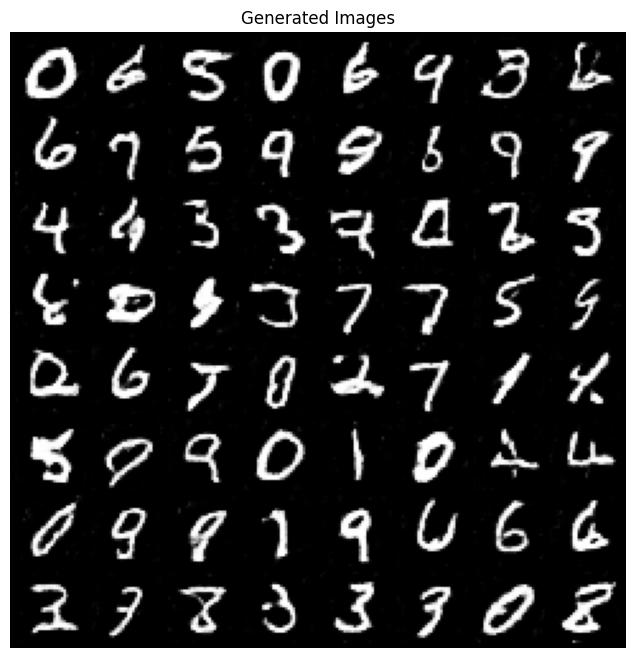

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 364MB/s]


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:00<00:00, 17724850.75it/s]


Extracting /root/.cache/torch/fidelity_datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/.cache/torch/fidelity_datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 475489.46it/s]


Extracting /root/.cache/torch/fidelity_datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.cache/torch/fidelity_datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 4486241.63it/s]


Extracting /root/.cache/torch/fidelity_datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.cache/torch/fidelity_datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 4939208.91it/s]

Extracting /root/.cache/torch/fidelity_datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.cache/torch/fidelity_datasets/MNIST/raw



{'inception_score_mean': 2.130472931864686, 'inception_score_std': 0.03198464494054337, 'frechet_inception_distance': 56.6506659631207}
{'inception_score_mean': 2.130472931864686, 'inception_score_std': 0.03198464494054337, 'frechet_inception_distance': 56.6506659631207}


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:        d_grads_mean ▃▃▄▄▄▅▄▄▄▄▅▁▄▄▆▄▄▅▅▄▅▆▄▆▅▆▄▅▅▆▄▅▅▆█▃▆▆▅▁
wandb:         d_grads_std ▂▅▃▃▃▄▄▃▃▃▄▅▂▆▄▄▄▃▄▃▅▂▂▄▂▄▃▃▂▁▅▃▁█▁▆▂▅▃▃
wandb:             dp_loss ▁▁▂▂▂▄▅▄▆▅▅▅▆▅▅▇▅▇▆▇▇▇▆▇▇▇▆▆▇▆█▇████▇▇█▇
wandb:               epoch ▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇██
wandb:        g_grads_mean ▅▄▅▅▅▅▆▄▅▁▄▅▄▄▄▆▅▅▄▅▆▄▆▄▆▅▆▅▆▃▆▃▅▄▄▄▆▅▆█
wandb:         g_grads_std ▄▁▁▁▁▂▁▃▂▂▁▂▃▂▂▃▄▁▃▃▂▃▂▂▂▃▃▃▃▃▄▂▃▃▃▁▃▂▃█
wandb:              loss_d ▁▂▃▂▂▂▂▂▂▃▇▁▁▃▃▂▃▂▅▂▂▂▂▃▂▂▂▂▅▆▇█▃▂▄▃▄▂▃▄
wandb:              loss_g ▆▇▁▂▂▁▃▂▅▃▆▇▅▇▄▆▅▅▅▇▇▆▆▆▇▆▆▇█▇▆▄▅▆▇▆▅▅▅▅
wandb: trainer/global_step ▁▁▁▂▂▂▂▁▂▂▂▃▁▃▃▃▃▃▄▁▄▄▄▅▅▁▁▆▆▁▆▆▆▇▇▇███▁
wandb: 
wandb: Run summary:
wandb:        d_grads_mean -0.03423
wandb:         d_grads_std 1.40139
wandb:             dp_loss 1.89825
wandb:               epoch 19
wandb:        g_grads_mean 0.00088
wandb:         g_grads_std 0.06126
wandb:              loss_d 0.71054
wand

Running NEVanilaGAN


wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250528_131819-aq7pgw08
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run NEVanilaGAN_2025-05-28 13:18:19.508089
wandb: ⭐️ View project at https://wandb.ai/developsviviani-clown-dev/Experiments
wandb: 🚀 View run at https://wandb.ai/developsviviani-clown-dev/Experiments/runs/aq7pgw08
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | critic    | CriticMNIST    | 128 K  | train
1 | generator | GeneratorMNIST | 600 K  | train
2 | encoder   | EncoderMNIST   | 1.4 M  | train
-----------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.660     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.


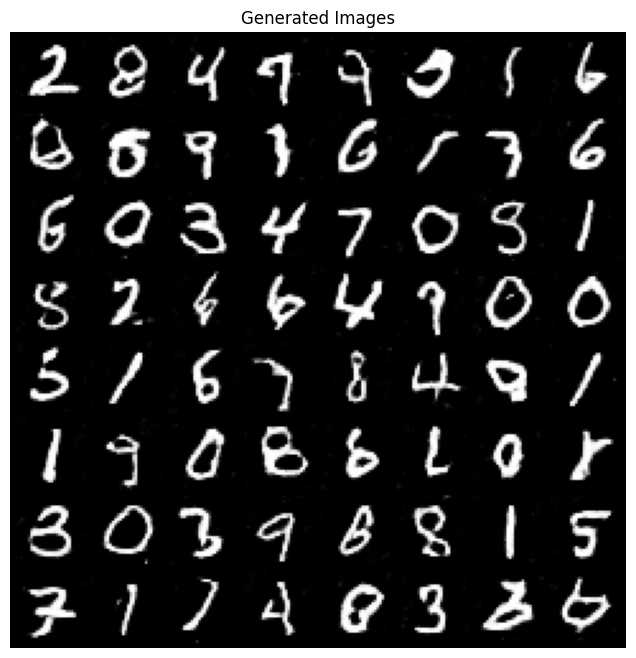

/usr/local/lib/python3.11/dist-packages/torch_fidelity/utils.py:328: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  out[n] = torch.load(p, map_location='cpu')
/usr/local/lib/

{'inception_score_mean': 2.0097214779923758, 'inception_score_std': 0.023934225448896545, 'frechet_inception_distance': 42.05071418707607}
{'inception_score_mean': 2.0097214779923758, 'inception_score_std': 0.023934225448896545, 'frechet_inception_distance': 42.05071418707607}


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:        d_grads_mean ▄▄▃▄▄▄▅▂▆▇▄▂▃▄▄▄█▅▃▇▅▆█▃▃▆▇▃▁█▁█▆▂▃█▁▃▅▂
wandb:         d_grads_std ▃▃▄▃▅▄▄▅▄▄▂▄▂▄▃▄▆▄█▄▄▆▁▄▃█▃▆▃▆▆▄▃▃▄▅▃▅▃▇
wandb:        e_grads_mean ▅▃▂▂█▂▂▃▂▂▃▄▁▃▃▃▃▂▃▂▃▂▃▃▄▃▂▂▃▃▃▃▃▂▃▃▃▃▃▃
wandb:         e_grads_std █▄▂▅▆▃▃▂▃▂▂▃▂▂▁▂▁▂▂▂▂▂▂▁▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁
wandb:               epoch ▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇█████
wandb:        g_grads_mean ▇▄▃▄▄▄▄▄▄▄▄▅▅▄▄▄▄▄▄▅▄▃▅▁▅▃▄▃▅▄▃█▂▅▄▄▅▄▃▄
wandb:         g_grads_std ▂▃▂▂▁▃▃▃▁▃▃▄▂▄▂▃▅▄▅▃▅▃▄▅▆▄▇▂▅▃▃▇▄▅▅▄█▃▇▇
wandb:             kl_loss ▃█▅▄▃▄▃▃▂▁▂▂▂▃▂▁▂▂▂▃▂▂▁▂▂▂▁▂▂▁▂▃▂▂▁▂▂▂▂▂
wandb:             loss_ae █▅▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:              loss_d ▆▄▃▃▅▄▂▂▂▃▂▂▄▂▃▂▂▂▂▃▃▃▆█▂▇▂▃▃▂▂▂▂▃▂▃▁▂▁▂
wandb:              loss_g █▄▄▄▁▂▃▂▁▂▃▃▃▃▂▃▃▅▂▄▃▄▆▄▂▄▃▄▃▄▄▂▃▃▃▁▂▅▂▃
wandb: trainer/global_step ▁▁▁▁▂▂▂▁▂▃▃▃▃▁▄▄▄▄▄▄▅▁▁▁▆▁▆▆▆▁▇▁▇▁▇▁███▁
wandb: 
wandb: Run summary:
wandb:        d_grads_mean 0.00643
wandb:

Running DistVanilaGAN


wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250528_132719-lv8nkz7u
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run DistVanilaGAN_2025-05-28 13:27:19.309543
wandb: ⭐️ View project at https://wandb.ai/developsviviani-clown-dev/Experiments
wandb: 🚀 View run at https://wandb.ai/developsviviani-clown-dev/Experiments/runs/lv8nkz7u
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | critic    | CriticMNIST    | 128 K  | train
1 | generator | GeneratorMNIST | 600 K  | train
2 | encoder   | EncoderMNIST   | 1.4 M  | train
-----------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.660     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.


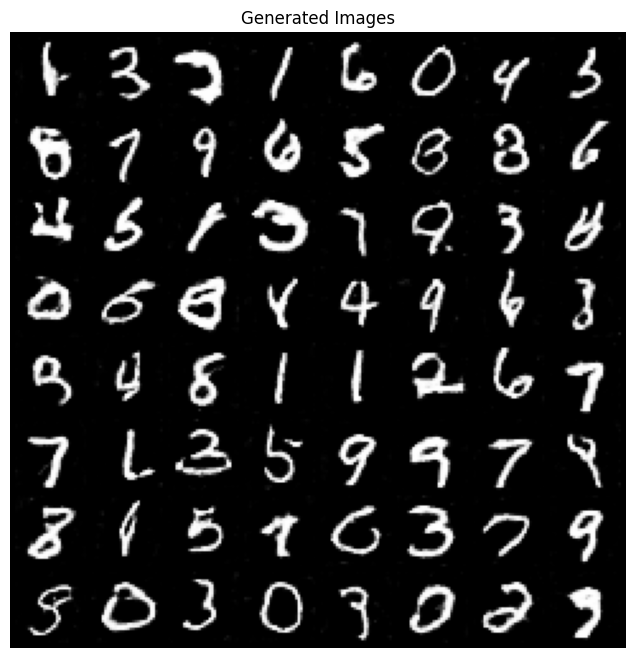

/usr/local/lib/python3.11/dist-packages/torch_fidelity/utils.py:328: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  out[n] = torch.load(p, map_location='cpu')
/usr/local/lib/

{'inception_score_mean': 2.0077304502965445, 'inception_score_std': 0.02318236183869852, 'frechet_inception_distance': 47.998513481455745}
{'inception_score_mean': 2.0077304502965445, 'inception_score_std': 0.02318236183869852, 'frechet_inception_distance': 47.998513481455745}


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:        d_grads_mean ▃▂▂▃▃▃▃▃▃▃▃▄▃▅▄▁▄▃▂▃▄▂▄▃▃▆▂▂▃█▂▄▄▄▆▄▄▄▆▃
wandb:         d_grads_std ▁▁▃▂▆▄▂▄▄▄▃▃▄▄▄▆▅▅▄▂▄▃▅▇▆█▃▅▄▆▆▅▆▄▅▄▅▃▂▄
wandb:        e_grads_mean ▅▅█▅▆▅█▅▄▄▃▄▅▃▅▆▇▄▃▄▆▃▅▁▇▁▅▆▅▄▃▄▅▄▅▅▅▆▃▆
wandb:         e_grads_std ▃▅█▄▃▄▅▃▄▅▃▃▄▃▃▂▂▃▃▄▂▂▂▂▃▂▂▁▁▁▂▂▂▁▃▁▁▁▁▁
wandb:               epoch ▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
wandb:        g_grads_mean ▅▄▃▄▄▆▅▄▅▄▄▅▆▄▄▃▃▄▃▄▄▄▄▄▂▄▃▃▆▃▇▆▃▄▁▅▂█▃▄
wandb:         g_grads_std ▄▅▄▂▂▁▂▃▂▃▃▃▃▅▅▅▅▄▅▅▂▄▄▇▅▅▇▄▆▂▇▄▇▅▆▆▇▆█▄
wandb:             loss_ae █▆▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:              loss_d ▁▅▆▄▄▄▄▄▄▄▅▅▄▅▄▄▄▄▄▄▄▄▄▄▄▄▅▅▄▄▄▄▄█▇▄▄▄▄▄
wandb:              loss_g ▃▇▁▂▃▄▄▃▄█▃▃▁▅▅▃▄▄▁▃▆▁▄▄▃▄▄▂▇▇▅▅▃▂▆▇▇▂▄▇
wandb: trainer/global_step ▁▂▂▂▁▂▁▂▂▂▃▃▃▃▃▄▄▁▄▄▅▅▅▅▁▅▅▆▆▆▆▆▇▁▇▇▁▇██
wandb: 
wandb: Run summary:
wandb:        d_grads_mean 0.009
wandb:         d_grads_std 0.343
wandb:        e_grads_mean 1e-05
wandb:    

Running NEVanilaGAN_hat


wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250528_133715-ve8fnp2b
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run NEVanilaGAN_hat_2025-05-28 13:37:15.538839
wandb: ⭐️ View project at https://wandb.ai/developsviviani-clown-dev/Experiments
wandb: 🚀 View run at https://wandb.ai/developsviviani-clown-dev/Experiments/runs/ve8fnp2b
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | critic    | CriticMNIST    | 128 K  | train
1 | generator | GeneratorMNIST | 600 K  | train
-----------------------------------------------------
728 K     Trainable params
0         Non-trainable params
728 K     Total params
2.914     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.


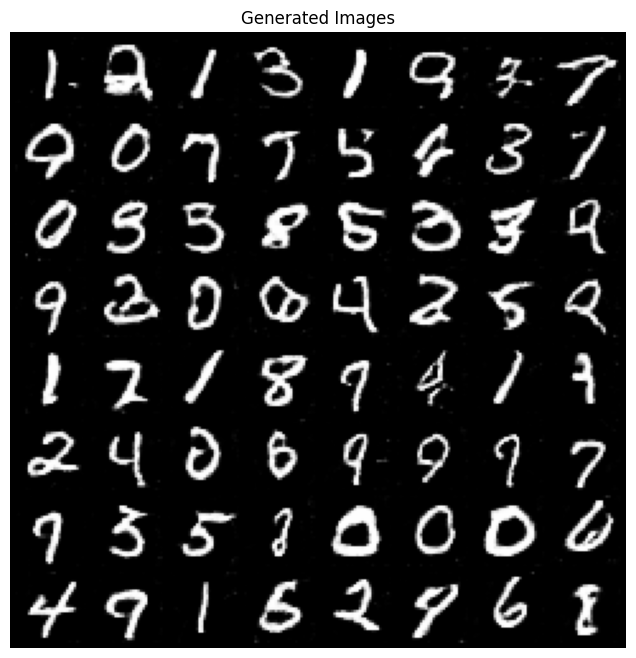

/usr/local/lib/python3.11/dist-packages/torch_fidelity/utils.py:328: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  out[n] = torch.load(p, map_location='cpu')
/usr/local/lib/

{'inception_score_mean': 2.0595951453574566, 'inception_score_std': 0.03131530047624817, 'frechet_inception_distance': 45.901703094156034}
{'inception_score_mean': 2.0595951453574566, 'inception_score_std': 0.03131530047624817, 'frechet_inception_distance': 45.901703094156034}


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:        d_grads_mean ▄▃▄▄▄▄▅▄▄▃▃▄▆▃▃▄█▅▅▆▆▄▇▅▅▆▅▆▆▅▅▆▅▅▄▁▅▆▄▃
wandb:         d_grads_std ▁▂▄▄▅▅▄▄▄▃▄▅▅▇▆▅▄▇▂▅▃▂▁▃▅▄▃▃▄▂▃▃▄▄▅▄▃▅▂█
wandb:               epoch ▁▁▁▁▁▂▂▂▂▂▂▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
wandb:        g_grads_mean ▇▆▄▄▄▅▃▅▇▅▃▂▆▇▃▅▆▃▄▄▃▂█▆▁▅▄▄▄▄▂▅▅▃▅▃▃▅▅▅
wandb:         g_grads_std ▅▃▁▂▂▁▁▃▃▃▄▄▃▅▃▄▅▅▅▃▃▆▅▄▂▂▆▆▆▅▂▅▅▇▇▇▆▇██
wandb:             kl_loss █▆▄▄▃▃▄▃▃▃▃▄▃▃▃▃▃▃▃▁▄▃▃▄▃▄▃▃▄▃▃▄▄▃▄▃▃▃▃▄
wandb:              loss_d ▂█▂▂▄▂▂▃▂▂▂▂▂▂▁▂▃▃▂▂▂▂▂▂▃▂▂▂▃▃▃▁▃▃▁▂▂▁▁▃
wandb:              loss_g ▇█▄▁▂▄▁▂▂▂▄▂▂▃▂▂▃▃▄▃▂▃▃▂▃▂▂▃▁▃▂▂▅▂▃▃▂▂▂▁
wandb: trainer/global_step ▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▁▆▇▇▇▇▇████▁
wandb: 
wandb: Run summary:
wandb:        d_grads_mean -0.00446
wandb:         d_grads_std 0.36283
wandb:               epoch 19
wandb:        g_grads_mean 7e-05
wandb:         g_grads_std 0.01347
wandb:             kl_loss 0.00181
wandb:              loss_d 0.92834
wandb:

Running StandardGAN


wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250528_134153-kobldq4h
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run StandardGAN_2025-05-28 13:41:53.182496
wandb: ⭐️ View project at https://wandb.ai/developsviviani-clown-dev/Experiments
wandb: 🚀 View run at https://wandb.ai/developsviviani-clown-dev/Experiments/runs/kobldq4h
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | critic    | CriticMNIST    | 128 K  | train
1 | generator | GeneratorMNIST | 600 K  | train
-----------------------------------------------------
728 K     Trainable params
0         Non-trainable params
728 K     Total params
2.914     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.


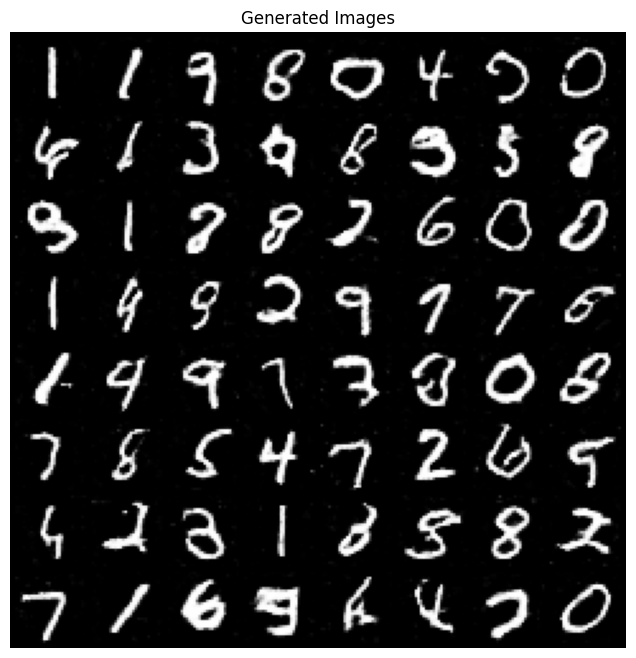

/usr/local/lib/python3.11/dist-packages/torch_fidelity/utils.py:328: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  out[n] = torch.load(p, map_location='cpu')
/usr/local/lib/

{'inception_score_mean': 2.1522819847520047, 'inception_score_std': 0.03687809433383289, 'frechet_inception_distance': 55.01545139581606}
{'inception_score_mean': 2.1522819847520047, 'inception_score_std': 0.03687809433383289, 'frechet_inception_distance': 55.01545139581606}


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:        d_grads_mean ▁▃▄▃▃▃▄▄▃▄▄▁▄▅▆▅█▃▅▃█▆▄▇█▆▄▄▅▅▅▂▅▄▅▅▄▅▆▅
wandb:         d_grads_std ▁▄▂▅▄▃▄▄▃▃▂▂▂▄█▂▃▃▄▃▅▅▂▄▂▂▂▃▂▅▃▄▅▂▃▄▃▂▅▃
wandb:               epoch ▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
wandb:        g_grads_mean ▃▅▅▇▆▄▂▂▅▂█▆▆▅▆▆▆█▄▄▇▅▄▃▃▄▃▅▄▃▅▁▄▂▄▆▄▆▁▂
wandb:         g_grads_std █▇▄▃▃▁▂▃▂▃▂▂▅▄▄▄▆▂▃▃▅▃▄█▅▃▆▅█▃▅▅▆▅▇▄▅▇▆▆
wandb:              loss_d ▁▁▁▁▄▂▂▃▂▂▂▂▂▂█▂▃▂▂▂▃▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▄▃
wandb:              loss_g █▆▅▃▄▃▄▃▃▃▄▄▄▃▄▅▄▂▆▁▅▅▃▃▅▃▅▄▆▃▆▅▃▄▄▃▃▄▅█
wandb: trainer/global_step ▁▁▁▁▂▂▂▁▂▂▂▃▃▃▃▁▄▄▄▁▅▁▅▅▁▅▅▆▆▁▆▆▆▁▇▇▁▇██
wandb: 
wandb: Run summary:
wandb:        d_grads_mean 0.00108
wandb:         d_grads_std 0.34775
wandb:               epoch 19
wandb:        g_grads_mean -0.00018
wandb:         g_grads_std 0.01722
wandb:              loss_d 0.97121
wandb:              loss_g 0.55246
wandb: trainer/global_step 19
wandb: 
wandb: 🚀 View run StandardGAN_2025

Running RpGAN


wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250528_134544-anj4x2bs
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run RpGAN_2025-05-28 13:45:44.737422
wandb: ⭐️ View project at https://wandb.ai/developsviviani-clown-dev/Experiments
wandb: 🚀 View run at https://wandb.ai/developsviviani-clown-dev/Experiments/runs/anj4x2bs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | critic    | CriticMNIST    | 128 K  | train
1 | generator | GeneratorMNIST | 600 K  | train
-----------------------------------------------------
728 K     Trainable params
0         Non-trainable params
728 K     Total params
2.914     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.


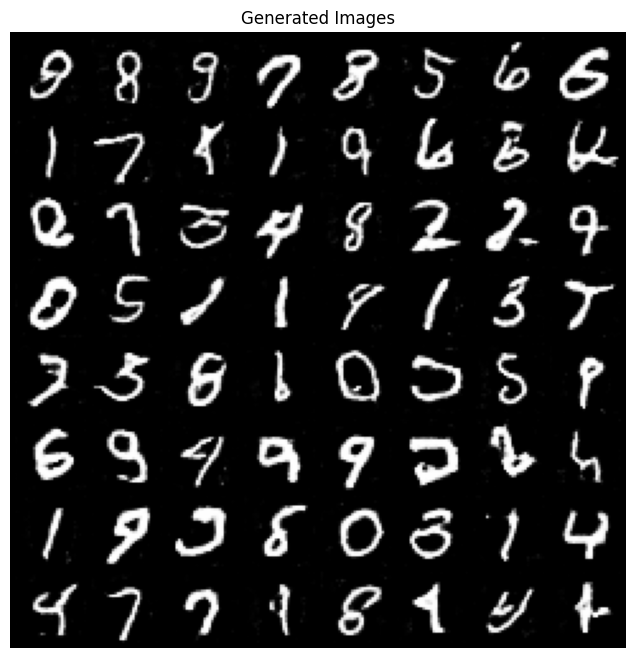

/usr/local/lib/python3.11/dist-packages/torch_fidelity/utils.py:328: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  out[n] = torch.load(p, map_location='cpu')
/usr/local/lib/

{'inception_score_mean': 2.1014800374543574, 'inception_score_std': 0.0239919812830242, 'frechet_inception_distance': 48.58006743364422}
{'inception_score_mean': 2.1014800374543574, 'inception_score_std': 0.0239919812830242, 'frechet_inception_distance': 48.58006743364422}


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:        d_grads_mean ▅▄▅▅▅▅▄▄▅▅▂▇▄▅▄█▆▇▄▆▃▇▆▅█▄▆▆▆▅▄▄▁█▅▄▁▅█▁
wandb:         d_grads_std ▁▂▂▁▂▃▂▁▃▅▁▂▃▂▇▅▄▅▃▂▂▂▄▄▂▆▅▅▂▁▄▃▄▄▄▃▃▆▄█
wandb:               epoch ▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇████
wandb:        g_grads_mean ▅▅▆▆▅▆▆▅▄▆▆▇▁▃▃█▄▃▆▄▅▅▅▁▅▅▅▆▄▄▅▅▅▇█▇▅▃▇▇
wandb:         g_grads_std ▁▂▃▃▂▆▃▄▃▄▅▅▅▃▄▅▆▆▆▆▃▇▇▇█▄▅▅▆▅▅▅▆▆█▅▇▇██
wandb:              loss_d ▂▁▁▁▃▁▁▁▁▁▂▂▁▁▁▁▂▁▁█▂▂▁▁█▁▂▅▅▂▂▂▁▁▂▁▁▁▁▁
wandb:              loss_g █▇▆▆▅▄▃▅▂▅▆▆▆▅▅▆▆▅▆▂▄▆▅▄▆▄▄▁▂▄▃▅▆▅▄▆▅▅▆▆
wandb: trainer/global_step ▁▁▁▂▂▂▂▂▂▂▁▃▁▄▄▄▄▄▅▁▅▅▁▆▆▁▆▆▆▁▇▁▇▇▇▇███▁
wandb: 
wandb: Run summary:
wandb:        d_grads_mean -0.02307
wandb:         d_grads_std 0.84412
wandb:               epoch 19
wandb:        g_grads_mean 0.0007
wandb:         g_grads_std 0.11152
wandb:              loss_d 0.00642
wandb:              loss_g 5.39703
wandb: trainer/global_step 19
wandb: 
wandb: 🚀 View run RpGAN_2025-05-28 

Running NERpGAN_hat


wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250528_134948-umjok4sd
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run NERpGAN_hat_2025-05-28 13:49:48.507473
wandb: ⭐️ View project at https://wandb.ai/developsviviani-clown-dev/Experiments
wandb: 🚀 View run at https://wandb.ai/developsviviani-clown-dev/Experiments/runs/umjok4sd
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | critic    | CriticMNIST    | 128 K  | train
1 | generator | GeneratorMNIST | 600 K  | train
-----------------------------------------------------
728 K     Trainable params
0         Non-trainable params
728 K     Total params
2.914     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.


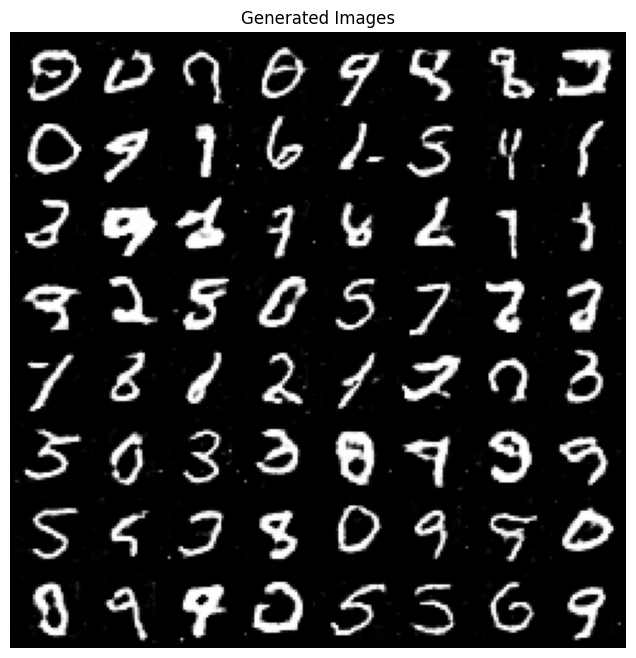

/usr/local/lib/python3.11/dist-packages/torch_fidelity/utils.py:328: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  out[n] = torch.load(p, map_location='cpu')
/usr/local/lib/

{'inception_score_mean': 2.088459795579011, 'inception_score_std': 0.021203144006555395, 'frechet_inception_distance': 62.44512421852929}
{'inception_score_mean': 2.088459795579011, 'inception_score_std': 0.021203144006555395, 'frechet_inception_distance': 62.44512421852929}


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:        d_grads_mean ▄▄▃▃▄▃▅▅▃▃▃▄▃▄▄▆▁▅▄▄▃█▃▅▄▁█▄▅▅▅▅▃▂▅▂▅▃▇▅
wandb:         d_grads_std ▂▂▁▂▃▂▃▂▂▂▄▃▂▁▂▃▃▇▁▂▅▅▆▁▃▅▂▃▃▂▃▅▄▂▆▄▆█▂▂
wandb:               epoch ▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
wandb:        g_grads_mean ▅▆▅▅▅▅▄▃▅▅▅▅▅▅▅▄▆▅▆▃▄▃▇▄▃▇▇▅▄▅▃▆▄▃▁█▅█▄▆
wandb:         g_grads_std ▁▃▂▂▂▃▂▃▄▄▅▂▄▅▅▅▄▄▅▅▆▄▆▅▇▂▄▅▇▆█▆█▇█▇▇▇▇▇
wandb:             kl_loss ▁██▇▇▆▇▇▇▆▇▇▆▇▇▆▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
wandb:              loss_d ▁▂▂▁▁▁▁▂▁▁▁▁▇▁▁▁▁▂▂▁▁▁▁▁▂▁▁▁▁█▁▁▁▁▁▁▁▁▁▄
wandb:              loss_g ▂▃▂▂▂▃▃▃▃▃▂▄▃▄▄▃▄▄▃▄▄▃▃▃▅▄▄▅▁▂▅▅▃▃▄▁▄▅▄█
wandb: trainer/global_step ▁▁▂▂▂▂▂▂▁▂▃▃▁▃▃▃▃▃▄▄▄▅▅▅▁▅▅▅▅▁▆▁▇▇▇▇▇▇▇█
wandb: 
wandb: Run summary:
wandb:        d_grads_mean -0.00796
wandb:         d_grads_std 0.31688
wandb:               epoch 19
wandb:        g_grads_mean 0.0008
wandb:         g_grads_std 0.06707
wandb:             kl_loss 0.00179
wandb:              loss_d 0.31176
wandb

Running DistRpGAN


wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250528_135442-o96g0glg
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run DistRpGAN_2025-05-28 13:54:42.423541
wandb: ⭐️ View project at https://wandb.ai/developsviviani-clown-dev/Experiments
wandb: 🚀 View run at https://wandb.ai/developsviviani-clown-dev/Experiments/runs/o96g0glg
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | critic    | CriticMNIST    | 128 K  | train
1 | generator | GeneratorMNIST | 600 K  | train
2 | encoder   | EncoderMNIST   | 1.4 M  | train
-----------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.660     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.


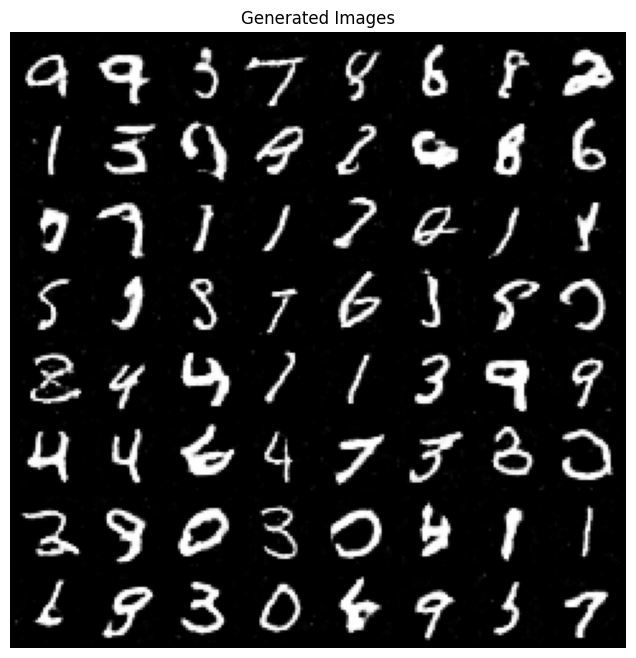

/usr/local/lib/python3.11/dist-packages/torch_fidelity/utils.py:328: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  out[n] = torch.load(p, map_location='cpu')
/usr/local/lib/

{'inception_score_mean': 1.981766020026202, 'inception_score_std': 0.01646280086134681, 'frechet_inception_distance': 61.66361717514036}
{'inception_score_mean': 1.981766020026202, 'inception_score_std': 0.01646280086134681, 'frechet_inception_distance': 61.66361717514036}


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:        d_grads_mean ▅▅▆▆▅▇▃▃▇█▃▅▆▆▁▁▆▄▆▂█▆▃▇▃▆▂▅▅▅▆▄▅▃▅▆▃▄▅▅
wandb:         d_grads_std ▁▁▃▂▂▃▃▂▂▃▂▃▄▂▁▄▃▃▃▂▃▄▄▂▃▂▂▂▅▃▁▂▃▃▃█▂▁▃▃
wandb:        e_grads_mean ▁▅▃▆█▃▅▆▂▄▆▆▇▇▅▅▅▄▄▆▅▅▆▄▆▃▄▅▄▃▄▃▄▄▆▆▄▆▅▅
wandb:         e_grads_std ▆▄▅█▆▆▃▅▃▃▅▄▄▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▂▂▁▁▁▁▂
wandb:               epoch ▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
wandb:        g_grads_mean ▄▅▅▄▆▅▅▅▄▄▃▄▅▄▃▅▄▃▂▃▂▃▇▂▁▅▄▆█▅▆▁▆▅▅▆▃▅▅▃
wandb:         g_grads_std ▁▁▂▂▃▃▃▃▄▂▄▂▂▄▄▅▃▃▄█▃▄▅▅▃▄▄▅▅▃▄▅▅▅▅▂▃▃▅▇
wandb:             loss_ae █▅▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:              loss_d ▂▁▂▁▁▂▁▁▁▁▁▄▁▁▁▁▄▁▁▁▁▁▁▁▃▁▁▄▁▁█▃▁▁▁▁▁▃▁▁
wandb:              loss_g ▁▁▄▄▃▅▅▄▅▂▄▅▂▄▄▆▆▅▅▇▃▅▅▆▄▆▅▇▆▇▆▂▄▆▇▇█▅▅█
wandb: trainer/global_step ▁▁▁▁▂▂▂▂▂▁▃▁▃▃▃▄▄▄▁▄▅▅▆▆▆▆▆▆▇▇▇▇▇█▁███▁▁
wandb: 
wandb: Run summary:
wandb:        d_grads_mean -0.00195
wandb:         d_grads_std 0.63862
wandb:        e_grads_mean 0.0
wandb: 

Running NERpGAN


wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250528_140455-ssd7xvdy
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run NERpGAN_2025-05-28 14:04:55.662390
wandb: ⭐️ View project at https://wandb.ai/developsviviani-clown-dev/Experiments
wandb: 🚀 View run at https://wandb.ai/developsviviani-clown-dev/Experiments/runs/ssd7xvdy
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | critic    | CriticMNIST    | 128 K  | train
1 | generator | GeneratorMNIST | 600 K  | train
2 | encoder   | EncoderMNIST   | 1.4 M  | train
-----------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.660     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.


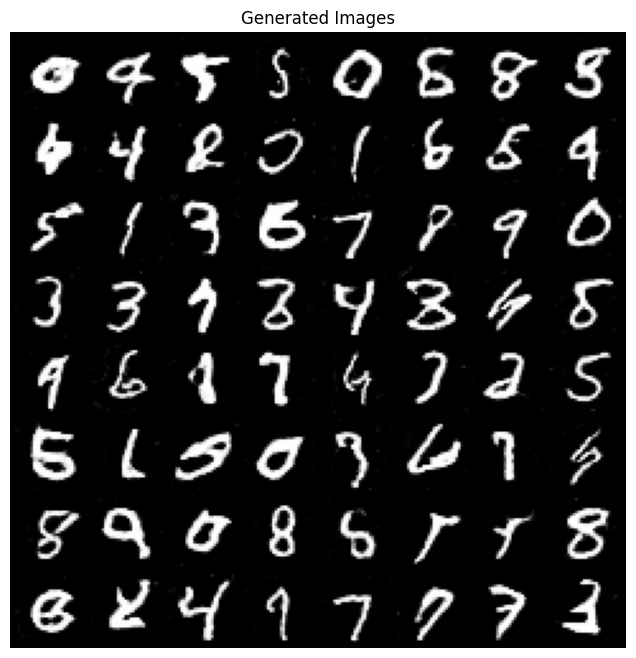

/usr/local/lib/python3.11/dist-packages/torch_fidelity/utils.py:328: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  out[n] = torch.load(p, map_location='cpu')
/usr/local/lib/

{'inception_score_mean': 1.9857430568822907, 'inception_score_std': 0.03321277331780037, 'frechet_inception_distance': 47.42291831806392}
{'inception_score_mean': 1.9857430568822907, 'inception_score_std': 0.03321277331780037, 'frechet_inception_distance': 47.42291831806392}


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:        d_grads_mean ▆▆▆▆▇▆▆█▅▄▇█▆█▄▄▅▂█▆▇█▃▅▆▆▂▅▇▅▄▇▁▂▅▆▅▆▅█
wandb:         d_grads_std ▁▁▂▇▂▄▃▂▄▅▃▂▅▃▂▅▅▃▅▆▄▄▄▂▄▃▃▃▄▄▂▄▃█▅▄▄▄▄▅
wandb:        e_grads_mean ▇▁▄▁▃▄█▅▁▃▆▄▄▄▄▆▅▃▆▃▆▅▅▅▅▄█▄▄▅▄▅▄▄▆▄▄▄▅▅
wandb:         e_grads_std ██▂▇▄▄▄▂▃▃▄▂▂▂▂▂▂▂▁▂▂▁▂▁▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁
wandb:               epoch ▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
wandb:        g_grads_mean ▄▅▇▆▅▅▆▅▅▅▅▅▆▄▅▅▆▄▄▆█▅▅▂▆▄▃▁▃▅▇▇▁▃▁█▃▃▅▂
wandb:         g_grads_std ▁▁▁▁▂▂▂▂▃▃▃▂▄▃▃▄▃▄▂▂▄▄▃▂▃▄▄▂▃▄▅▄▄▃▅▄▂▄▄█
wandb:             kl_loss █▇▇▅▆▅▄▄▄▃▅▃▄▄▂▂▃▄▃▂▃▂▃▂▁▂▂▃▂▂▂▃▂▂▃▃▃▃▂▂
wandb:             loss_ae █▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:              loss_d ▆▄▄▇▃▄▃▂▅▃▂▁█▂▂▂▂▃▂▂▃▁▂▂▂▁▁▁▅▂▂▁▁▂▂▁▂▁▁▁
wandb:              loss_g ▁▁▂▂▃▅▆▅▅▄▅▆▄▄▅▄▅▅▄▃▅▃▄▅▅▆▆▆▅▅▅▅█▅▆▅▆▆▇▆
wandb: trainer/global_step ▁▁▂▂▂▂▂▂▃▃▃▃▁▁▄▁▄▄▅▅▁▅▅▁▅▅▆▆▆▆▆▆▇▁▇▇▇▇▇█
wandb: 
wandb: Run summary:
wandb:        d_grads_mean -0.00344
wandb

Running DpRpGAN


wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250528_141406-zq47u46e
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run DpRpGAN_2025-05-28 14:14:06.073148
wandb: ⭐️ View project at https://wandb.ai/developsviviani-clown-dev/Experiments
wandb: 🚀 View run at https://wandb.ai/developsviviani-clown-dev/Experiments/runs/zq47u46e
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | critic    | CriticMNIST    | 128 K  | train
1 | generator | GeneratorMNIST | 600 K  | train
-----------------------------------------------------
728 K     Trainable params
0         Non-trainable params
728 K     Total params
2.914     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.


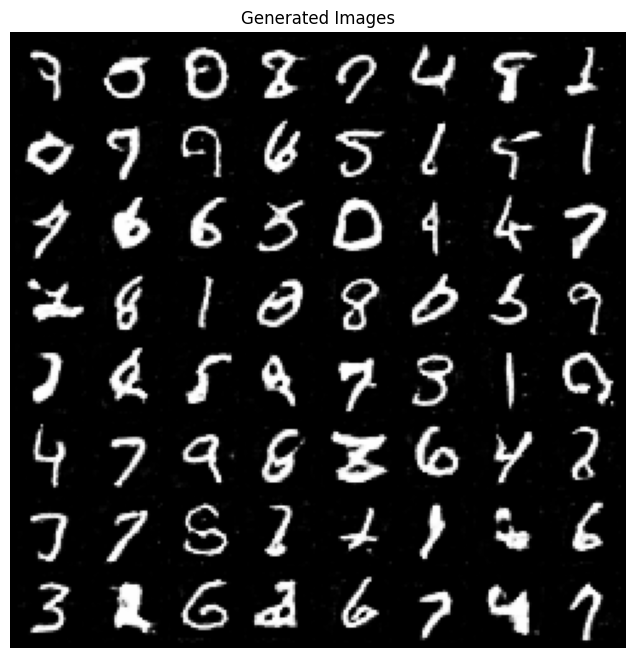

/usr/local/lib/python3.11/dist-packages/torch_fidelity/utils.py:328: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  out[n] = torch.load(p, map_location='cpu')
/usr/local/lib/

{'inception_score_mean': 2.1078524846240962, 'inception_score_std': 0.02301932248142424, 'frechet_inception_distance': 62.22464210762598}
{'inception_score_mean': 2.1078524846240962, 'inception_score_std': 0.02301932248142424, 'frechet_inception_distance': 62.22464210762598}


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:        d_grads_mean ▅▄▄▅▅▅▅▅▆▄▆▄▅▃▃▅▅▃▆▄▆▂▇▄▆▅█▄▃▅▂▁▃▅▁▄▃▃█▆
wandb:         d_grads_std ▃▂▃▄▄▂▂▁▂▂▃▂▂▄▂▁▂▂▁▂▁▂▃▄▄▄▂▄▂▅▁▁▂▃█▃▂▅▆▆
wandb:             dp_loss ▁▃▂▂▂▂▃▂▂█▃▆▄▃▃▅▄▄▇▅▄▄▅▇▅▅▅▇▆▅▆▆▅▅▅▆▆▅▅▅
wandb:               epoch ▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
wandb:        g_grads_mean ▆▆▆▅▄▅▄▄▄▄▅▅▄▄▅▃▄▄▅▇▄▃▅▄▂▅█▄▅▃▄▄▂▄▇▆▇▅▁▂
wandb:         g_grads_std ▂▁▃▂▃▂▂▃▃▄▃▄▆▂▃▄▂▃▅▅▄█▅▅▆▄▅▆▅▇▂▂▆▄▂▅▇▆▆▆
wandb:              loss_d ▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▂▁▁▂▁▁▁▁▁▆▂▁▁▁▁▁▁
wandb:              loss_g ▁▃▄▄▄▅▅▅▅▆▅▄▆▆▄▆▆▆▆▅▆▆▆▅▆█▄▅▇▇▆▇▅▆█▇▇▇██
wandb: trainer/global_step ▁▁▁▂▂▂▂▁▂▂▁▃▃▃▃▃▁▄▄▁▁▅▅▅▅▅▅▆▁▆▇▁▇▇▁▇▇▇██
wandb: 
wandb: Run summary:
wandb:        d_grads_mean -0.00746
wandb:         d_grads_std 0.57063
wandb:             dp_loss 1.93044
wandb:               epoch 19
wandb:        g_grads_mean -1e-05
wandb:         g_grads_std 0.14945
wandb:              loss_d 0.00529
wandb

Running RpGAN_R1R2


wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250528_141905-zrcl833z
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run RpGAN_R1R2_2025-05-28 14:19:05.629805
wandb: ⭐️ View project at https://wandb.ai/developsviviani-clown-dev/Experiments
wandb: 🚀 View run at https://wandb.ai/developsviviani-clown-dev/Experiments/runs/zrcl833z
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | critic    | CriticMNIST    | 128 K  | train
1 | generator | GeneratorMNIST | 600 K  | train
-----------------------------------------------------
728 K     Trainable params
0         Non-trainable params
728 K     Total params
2.914     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.


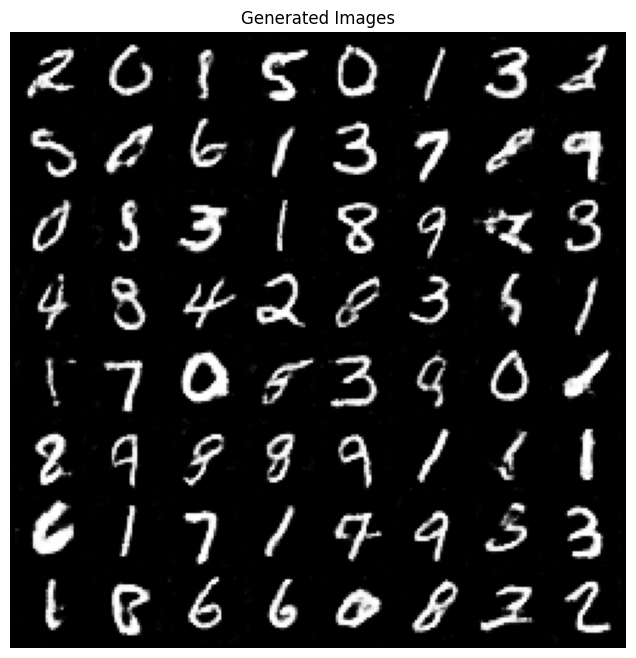

/usr/local/lib/python3.11/dist-packages/torch_fidelity/utils.py:328: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  out[n] = torch.load(p, map_location='cpu')
/usr/local/lib/

{'inception_score_mean': 2.1961854129263694, 'inception_score_std': 0.028907195009010386, 'frechet_inception_distance': 41.57529767804934}
{'inception_score_mean': 2.1961854129263694, 'inception_score_std': 0.028907195009010386, 'frechet_inception_distance': 41.57529767804934}


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:        d_grads_mean █▆▃▂▄▄▄▃▃▁▁▃▃▃▂▂▄▃▃▃▄▃▂▁▃▃▂▂▂▃▃▂▂▁▃▂▂▂▂▂
wandb:         d_grads_std ██▂▂▃▂▃▂▂▂▁▂▂▂▁▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
wandb:               epoch ▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇███
wandb:        g_grads_mean ▆█▄▆▁▂▄▄▅▇▅▄▄▆▄▅▄▅▄▅▄▃▄▄▄▄▅▄▄▄▄▄▄▃▄▄▄▃▄▄
wandb:         g_grads_std █▂▂▁▇▇▇█▄▅▄▄▄▄▄▃▄▃▃▃▅▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▄
wandb:              loss_d ▃▁▁▇▇▇▇▇▇▇▇▇█▇▇▇▇█▇█▇▇▇▇████████████████
wandb:              loss_g ▅▄█▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: trainer/global_step ▁▁▁▂▂▂▂▂▁▁▃▁▄▄▄▁▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▁▁▇██▁█▁
wandb: 
wandb: Run summary:
wandb:        d_grads_mean -7e-05
wandb:         d_grads_std 0.00516
wandb:               epoch 19
wandb:        g_grads_mean 1e-05
wandb:         g_grads_std 0.00119
wandb:              loss_d 0.66918
wandb:              loss_g 0.78208
wandb: trainer/global_step 19
wandb: 
wandb: 🚀 View run RpGAN_R1R2_2025-05-2

Running NERpGAN_hat+R1R2


wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250528_142638-heyxlccc
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run NERpGAN_hat+R1R2_2025-05-28 14:26:38.627008
wandb: ⭐️ View project at https://wandb.ai/developsviviani-clown-dev/Experiments
wandb: 🚀 View run at https://wandb.ai/developsviviani-clown-dev/Experiments/runs/heyxlccc
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | critic    | CriticMNIST    | 128 K  | train
1 | generator | GeneratorMNIST | 600 K  | train
-----------------------------------------------------
728 K     Trainable params
0         Non-trainable params
728 K     Total params
2.914     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.


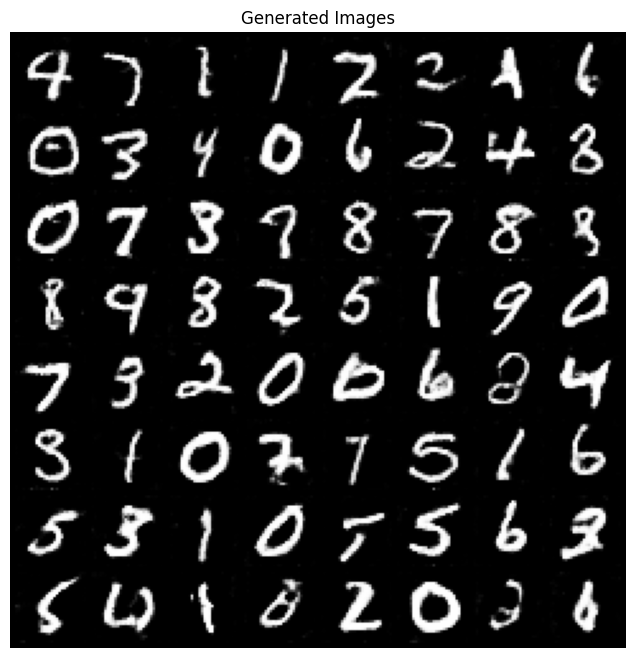

/usr/local/lib/python3.11/dist-packages/torch_fidelity/utils.py:328: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  out[n] = torch.load(p, map_location='cpu')
/usr/local/lib/

{'inception_score_mean': 2.19656989655862, 'inception_score_std': 0.027675235127863764, 'frechet_inception_distance': 33.99908143324143}
{'inception_score_mean': 2.19656989655862, 'inception_score_std': 0.027675235127863764, 'frechet_inception_distance': 33.99908143324143}


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:        d_grads_mean █▇▃▃▄▃▅▁▃▁▄▃▃▃▄▄▂▄▃▃▃▃▃▃▄▃▃▃▄▄▃▃▃▃▃▃▃▃▃▃
wandb:         d_grads_std ██▃▂▃▂▂▂▂▂▂▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:               epoch ▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
wandb:        g_grads_mean █▅▃▃▂▄▄▄▆▂▁▄▂▅▃▄▄▅▃▄▄▄▄▄▃▄▄▄▄▄▄▄▃▄▄▄▃▃▃▃
wandb:         g_grads_std ▃▁▁█▅▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁
wandb:             kl_loss ▁▇▆▇▇▆▇▆▇▇▇▇▇▇▇▇▅▇▇▇▇▇▇▇▇▇▇▇██▇▇▇██▇▇▇▇▅
wandb:              loss_d ▃▃▁▁▁▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████
wandb:              loss_g ▆█▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: trainer/global_step ▁▁▁▂▁▂▂▂▂▃▃▃▄▄▄▁▄▄▁▄▅▅▅▅▅▆▆▆▆▆▆▁▇▇▇▇▇███
wandb: 
wandb: Run summary:
wandb:        d_grads_mean 7e-05
wandb:         d_grads_std 0.00634
wandb:               epoch 19
wandb:        g_grads_mean -1e-05
wandb:         g_grads_std 0.00119
wandb:             kl_loss 0.00176
wandb:              loss_d 0.67622
wandb:  

Running DistRpGAN+R1R2


wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250528_143500-x0lfenhk
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run DistRpGAN+R1R2_2025-05-28 14:35:00.203653
wandb: ⭐️ View project at https://wandb.ai/developsviviani-clown-dev/Experiments
wandb: 🚀 View run at https://wandb.ai/developsviviani-clown-dev/Experiments/runs/x0lfenhk
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | critic    | CriticMNIST    | 128 K  | train
1 | generator | GeneratorMNIST | 600 K  | train
2 | encoder   | EncoderMNIST   | 1.4 M  | train
-----------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.660     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.


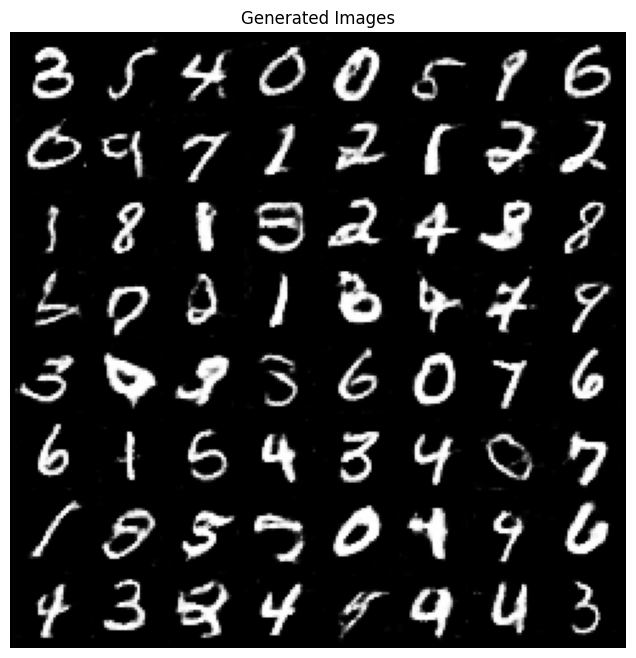

/usr/local/lib/python3.11/dist-packages/torch_fidelity/utils.py:328: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  out[n] = torch.load(p, map_location='cpu')
/usr/local/lib/

{'inception_score_mean': 2.146132233181496, 'inception_score_std': 0.032383268710339135, 'frechet_inception_distance': 34.10542370200713}
{'inception_score_mean': 2.146132233181496, 'inception_score_std': 0.032383268710339135, 'frechet_inception_distance': 34.10542370200713}


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:        d_grads_mean █▆▆█▆▇▃▂▁▂▃▄▁▂▂▄▃▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▃▃
wandb:         d_grads_std ▇▇███▂▂▃▂▂▂▂▂▂▂▁▁▁▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
wandb:        e_grads_mean ▆▆▃▃▃▄█▄▃▃▂▂▄▂▄▅▃▃▃▄▃▆▂▃▁▂▅▄▅▅▃▃▅▄▂▂▃▆▃▃
wandb:         e_grads_std ▆▇▆▆▆█▅▄▅▅▂▄█▃▄▁▃▄▂▃▄▂▃▂▂▃▃▃▂▁▂▂▂▁▁▂▂▂▁▁
wandb:               epoch ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
wandb:        g_grads_mean ▂▃▂▂▂▂█▄▂▂▃▄▃▂▂▃▃▂▁▂▁▂▂▂▃▄▂▄▂▂▃▃▂▂▂▂▂▁▂▃
wandb:         g_grads_std ▆▁▁▁▁▁▁█▂▃▂▃▃▃▂▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁
wandb:             loss_ae █▄▄▄▄▃▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:              loss_d ▄▂▂▁▁▁▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇▇▇▇▇▇████████████
wandb:              loss_g ▃▃▄▅▆▇██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: trainer/global_step ▁▁▁▁▂▂▁▂▃▁▃▃▁▃▁▁▄▄▁▄▅▅▅▁▅▆▆▁▆▆▆▇▁▇▁▇▁███
wandb: 
wandb: Run summary:
wandb:        d_grads_mean -5e-05
wandb:         d_grads_std 0.00574
wandb:        e_grads_mean -0.0
wandb:  

Running NERpGAN+R1R2


wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250528_144831-7kuu63kg
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run NERpGAN+R1R2_2025-05-28 14:48:31.665470
wandb: ⭐️ View project at https://wandb.ai/developsviviani-clown-dev/Experiments
wandb: 🚀 View run at https://wandb.ai/developsviviani-clown-dev/Experiments/runs/7kuu63kg
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | critic    | CriticMNIST    | 128 K  | train
1 | generator | GeneratorMNIST | 600 K  | train
2 | encoder   | EncoderMNIST   | 1.4 M  | train
-----------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.660     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.


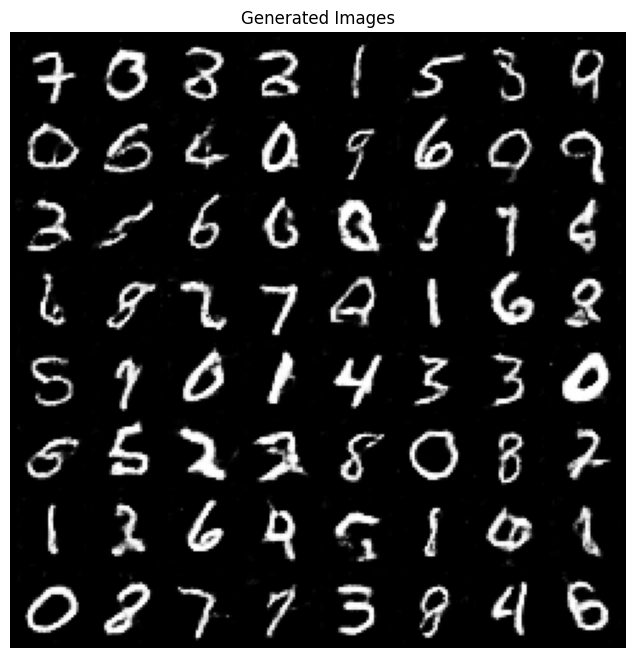

/usr/local/lib/python3.11/dist-packages/torch_fidelity/utils.py:328: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  out[n] = torch.load(p, map_location='cpu')
/usr/local/lib/

{'inception_score_mean': 2.0483884974493702, 'inception_score_std': 0.02516182310218478, 'frechet_inception_distance': 41.54298307510811}
{'inception_score_mean': 2.0483884974493702, 'inception_score_std': 0.02516182310218478, 'frechet_inception_distance': 41.54298307510811}


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:        d_grads_mean █▄▃▄▃▂▃▃▄▃▆▃▄▃▂▂▃▂▁▂▁▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂
wandb:         d_grads_std ▇▇▇▇▇▇▇▇▇▇▇█▇██▁▁▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:        e_grads_mean ▃▃▆▅▁▅▅▃▆▄▄▂▄█▆▆▅▄▅▅▄▅▅▄▃▃▅▄▄▅▅▆▅▄▄▅▅▅▄▅
wandb:         e_grads_std ██▃▆▇▂▂▃▆▃▂▃▃▃▂▅▂▂▅▃▂▃▃▂▃▂▂▁▃▂▁▁▁▂▁▂▂▂▁▁
wandb:               epoch ▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
wandb:        g_grads_mean █▄▂▂▁▃▅▃▃▃▂▄▆▆▄▅▄▆▄▂▂▇▇▂█▄▄▂▆▂▃▃▄▂▅▄▄▄▃▄
wandb:         g_grads_std ▇▃▃▅▄▄▂▁▂▁▇██▇▆▇▇▇▇█▆▇▆▆▆▆▆▆▅▅▆▅▅▅▅▅▅▄▄▅
wandb:             kl_loss █▇▄▂▂▂▂▂▂▁▁▁▁▁▁▇██▇▇▇▇▇▇▇▇▆▆▇▆▆▅▆▆▆▆▆▇▇▇
wandb:             loss_ae █▆▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:              loss_d ▃▁▁▁▁▁▇▇▇▇▇▇▇▇▇██▇▇▇████████████████████
wandb:              loss_g ▄▄▄▅▆▆▆▅▆▇▇▇███▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: trainer/global_step ▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▁▅▅▆▆▁▆▆▆▇▇▇▇▇█▁█▁
wandb: 
wandb: Run summary:
wandb:        d_grads_mean 1e-05
wandb:  

Running DpRpGAN+R1R2


wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250528_150110-ksl5gy5s
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run DpRpGAN+R1R2_2025-05-28 15:01:10.517417
wandb: ⭐️ View project at https://wandb.ai/developsviviani-clown-dev/Experiments
wandb: 🚀 View run at https://wandb.ai/developsviviani-clown-dev/Experiments/runs/ksl5gy5s
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | critic    | CriticMNIST    | 128 K  | train
1 | generator | GeneratorMNIST | 600 K  | train
-----------------------------------------------------
728 K     Trainable params
0         Non-trainable params
728 K     Total params
2.914     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.


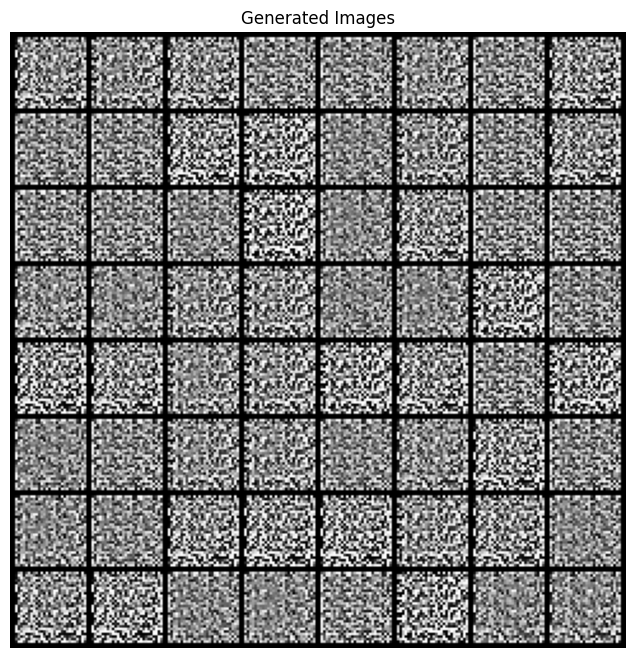

/usr/local/lib/python3.11/dist-packages/torch_fidelity/utils.py:328: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  out[n] = torch.load(p, map_location='cpu')
/usr/local/lib/

{'inception_score_mean': 1.1546793283131738, 'inception_score_std': 0.005488732354302654, 'frechet_inception_distance': 394.4617702529098}
{'inception_score_mean': 1.1546793283131738, 'inception_score_std': 0.005488732354302654, 'frechet_inception_distance': 394.4617702529098}


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:        d_grads_mean █▆▆▇▆▇▇▇▇▇▃▃▃▃▃▃▁▄▄▄▅▄▅▅▆▅▆▄▅▆▆▆▇█▇▇▅▆▆▇
wandb:         d_grads_std ▁▁▁▁▁▂▂▂▂▂▄▃▄▅▅▄▄▄▅▄▄▅▄▄▄▅▃▅█▆▅▄▅▄▅▄▄▃▃▃
wandb:             dp_loss █▄▄▄▃▃▃▃▃▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂
wandb:               epoch ▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇████
wandb:        g_grads_mean ▃▆▃▃▃▃▄▃▃▄▄▄▁▅▄▅▄▃▁▄▃▁▃▆▅▁▂▃▆▃▅█▂▆▂▁▃▅▅▅
wandb:         g_grads_std ▃▃▇▅▃▆▃▅▃▄▄▁▂▃▂▂▄▄▆▃▅▆▅█▆▅▅█▄▄▅▇▅▆▆▅▄▄▄▆
wandb:              loss_d █▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:              loss_g ▇▂▆▇█▇▄▂▁▂▂▂▃▃▅▃▄▄▇▅▄▆▅▅▆▅▆▅▆▇▅▆▅▇▇▇██▇▇
wandb: trainer/global_step ▁▂▂▂▂▁▃▁▃▃▃▁▃▃▄▄▄▁▄▄▅▅▅▁▅▆▆▆▆▁▆▆▁▇▁▇▁▇██
wandb: 
wandb: Run summary:
wandb:        d_grads_mean -0.00125
wandb:         d_grads_std 0.07975
wandb:             dp_loss 1.12361
wandb:               epoch 19
wandb:        g_grads_mean -0.0
wandb:         g_grads_std 0.02093
wandb:              loss_d 0.00147
wandb: 

In [15]:
for name, model_fn in EXPERIMENTS.items():
    print(f"Running {name}")

    wandb_logger = WandbLogger(
        project='Experiments',
        save_dir='',
        log_model=True,
        name=name + "_" + str(datetime.now())
    )

    trainer = L.Trainer(
        max_epochs=MAX_EPOCHS,
        logger=wandb_logger,
        deterministic=True
    )

    model = model_fn()

    trainer.fit(model=model, train_dataloaders=train_loader)

    generate_some_examples(model)

    metrics = compute_metrics(model, seed=SEED, latent_space_dim=LATENT_SPACE_DIM, input2=ROOT_TO_REGISTER_DATASET_FOR_FID)
    print(metrics)

    results.loc[name] = metrics

    wandb.finish()

    # Чистим память
    del model
    del trainer
    del wandb_logger
    gc.collect()
    torch.cuda.empty_cache()

## Results

In [16]:
results

inception_score_mean  inception_score_std  \
DpVanilaGAN                   2.130473             0.031985   
NEVanilaGAN                   2.009721             0.023934   
DistVanilaGAN                 2.007730             0.023182   
NEVanilaGAN_hat               2.059595             0.031315   
StandardGAN                   2.152282             0.036878   
RpGAN                         2.101480             0.023992   
NERpGAN_hat                   2.088460             0.021203   
DistRpGAN                     1.981766             0.016463   
NERpGAN                       1.985743             0.033213   
DpRpGAN                       2.107852             0.023019   
RpGAN_R1R2                    2.196185             0.028907   
NERpGAN_hat+R1R2              2.196570             0.027675   
DistRpGAN+R1R2                2.146132             0.032383   
NERpGAN+R1R2                  2.048388             0.025162   
DpRpGAN+R1R2                  1.154679             0.005489   

                  frechet_inception_distance  
DpVanilaGAN                        56.650666  
NEVanilaGAN                        42.050714  
DistVanilaGAN                      47.998513  
NEVanilaGAN_hat                    45.901703  
StandardGAN                        55.015451  
RpGAN                              48.580067  
NERpGAN_hat                        62.445124  
DistRpGAN                          61.663617  
NERpGAN                            47.422918  
DpRpGAN                            62.224642  
RpGAN_R1R2                         41.575298  
NERpGAN_hat+R1R2                   33.999081  
DistRpGAN+R1R2                     34.105424  
NERpGAN+R1R2                       41.542983  
DpRpGAN+R1R2                      394.461770